In [35]:
#Load needed Libraries
#For converting address to geographic coordinates
from geopy.geocoders import Nominatim
#Loading bar
from tqdm import tqdm
#Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
#TO deal with imbalance dataset
from imblearn.over_sampling import SMOTE
#Libraries
import pandas as pd
import numpy as np
import re
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Check to see if we loaded our data properly 
traffic = pd.read_csv(r"C:\Users\whift\Downloads\pd_collisions_details_datasd.csv", dtype = {'report_id':str})
traffic.head()

,report_id,date_time,person_role,person_injury_lvl,person_veh_type,veh_type,veh_make,veh_model,police_beat,address_no_primary,...,address_sfx_primary,address_pd_intersecting,address_name_intersecting,address_sfx_intersecting,violation_section,violation_type,charge_desc,injured,killed,hit_run_lvl
0,192016,2015-03-19 12:00:00,PARKED VEHICLE OCCUPANT,NaN,NaN,AUTOMOBILE,FORD,NaN,622,5200,...,ROAD,,,,MISC-HAZ,VC,MISCELLANEOUS HAZARDOUS VIOLATIONS OF THE VEHI...,0,0,MISDEMEANOR
1,190012,2015-03-24 03:05:00,DRIVER,VISABLE,NaN,NaN,NISSAN,ALTIMA,626,1000,...,STREET,,,,22107,VC,TURNING MOVEMENTS AND REQUIRED SIGNALS,2,0,NaN
2,191866,2015-03-27 23:56:00,DRIVER,PAIN,NaN,LIGHT DUTY TRUCK,FORD,F150,613,2800,...,STREET,,,,22107,VC,TURNING MOVEMENTS AND REQUIRED SIGNALS,1,0,NaN
3,185207,2015-07-06 11:45:00,DRIVER,NaN,NaN,NaN,FORD,MUSTANG,813,2800,...,BOULEVARD,,,,20002(A),VC,HIT AND RUN,0,0,MISDEMEANOR
4,1608987,2015-08-22 13:45:00,DRIVER,NaN,NaN,TRAILER,YAMAHA,NaN,999,0,...,,,,,MISC-HAZ,VC,MISCELLANEOUS HAZARDOUS VIOLATIONS OF THE VEHI...,1,0,NaN


<span style="color: white"> Start of Data Preprocessing </span>

In [3]:
#Excludes the charges that has nothing to do with the bicyclist being the one at fault
#Same script but keeps the date and time so we can categorize 

exclude_charges = [
    'BICYCLE HEADLIGHT/REFLECTOR VIOL (I)',
    'BICYCLE MUST STOP BEFORE INTERSECTION AT RED LIGHT (I)',
    'BICYCLE OPERATORS SHALL OBEY VEHICLE LAWS (I)',
    'BICYCLIST SHALL OBEY SIGNAL AND YIELD TO LAWFUL TRAFFIC (I)',
    'BIKE LANE - UNSAFE MOVEMENT (I)',
    'BRAKES REQUIRED ON BICYCLE (I)',
    'CARRY ARTCL:PREV AT LEAST ONE HAND ON BICYCLE HANDLEBARS (I)',
    'DISOBEY CONSTRUCTION WARNING DEV (I)',
    'DRVG ON SIDEWALK (I)',
    'FAIL TO RIDE BICYCLE:RIGHT EDGE OF ROADWAY (I)',
    'FAILED TO STOP FOR STOP SIGN (I)',
    'FAILURE TO MERGE INTO BICYCLE LANE BEFORE MAKING RIGHT TURN (I)',
    'LANE USAGE:BICYCLIST FAILURE TO RIDE IN BIKE LANE (I)',
    'LANE USAGE:OPERATING BICYCLE ON WRONG SIDE OF ROAD (I)',
    'MOTORIZED BICYCLE: SAFETY/EQUIPMENT REQUIREMENTS (I)',
    'MUST WEAR HELMET WHILE OPERATE CLASS 3 ELECTRIC BICYCLE (I)',
    'NO BICYCLE LIGHT (I)',
    'OPERATE MOTORIZED BIKE IN BIKE LANE SAFELY (I)',
    'PARKING BICYCLE ON SIDEWALK/PEDESTRIAN PATH (I)',
    'RED REFLECTOR ON REAR OF BIKE REQUIRED (I)',
    'RIDING BICYCLE UNDER INFLUENCE OF ALCOHOL AND/OR DRUGS(IBR 90E)',
    'SIGNAL LIGHTS:CIRCULAR GREEN (I)',
    'SIGNAL LIGHTS:CIRCULAR RED (I)',
    'SIGNAL LIGHTS:FLASHING RED (I)',
    'SIGNAL LIGHTS:PEDESTRIAN CIRCULAR RED OR RED ARROW (I)',
    'SIGNAL LIGHTS:RED ARROW (I)',
    'SIGNAL LIGHTS:RIGHT TURN ON RED (I)',
    'SUDDEN STOP W/O SIGNALING (I)',
    'TURNS:ILLEGAL U-TURN IN A BUSINESS DISTRICT (I)',
    'TURNS:ILLEGAL U-TURN IN A RES DISTRICT (I)',
    'TURNS:ILLEGAL U-TURN OBSTRUCTED VIEW (I)',
    'TURNS:IMPROPER LEFT HAND TURN (I)',
    'TURNS:IMPROPER RIGHT HAND TURN (I)',
    'TURNS:UNSAFE TURN AND/OR NO TURN SIGNAL (I)',
    'UNSAFE START ON HWY (I)',
    'UNSAFE TURNING MOVEMENT (I)'
]

#Drop the charges that are not deemed to be caused by accidents
traffic = traffic[~traffic['charge_desc'].isin(exclude_charges)]

#Convert the column date_time into datetime for easier time filtering
traffic['date_time'] = pd.to_datetime(traffic['date_time'], format = '%Y-%m-%d %H:%M:%S')

#Filter the years 2020 through 2025 only
traffic_2020_2025 = traffic[(traffic['date_time'].dt.year >= 2020) & (traffic['date_time'].dt.year <= 2025)]

#Filter data to bicyclist accidents, set with injury greater than 1 to focus on crashes and avoid events that are just citations
bike_accidents = traffic_2020_2025[(traffic_2020_2025['person_role'] == 'BICYCLIST') & (traffic_2020_2025['injured'] >= 1) ]

#Now we drop any duplicates because if different people were involved in the same accident but have the same report_id then we should just count
#The first instance because it counts as one whole accident.
bike_accidents = bike_accidents.drop_duplicates(subset = ['report_id', 'date_time']).reset_index(drop = True)


#See a good amount of the new filtered data
bike_accidents.head()


,report_id,date_time,person_role,person_injury_lvl,person_veh_type,veh_type,veh_make,veh_model,police_beat,address_no_primary,...,address_sfx_primary,address_pd_intersecting,address_name_intersecting,address_sfx_intersecting,violation_section,violation_type,charge_desc,injured,killed,hit_run_lvl
0,20200140,2020-01-06 17:05:47,BICYCLIST,SEVERE,NaN,BICYCLE,GIANNINI,NaN,531,1900,...,DRIVE,,,,22350,VC,UNSAFE SPEED (BASIC SPEED LAW) (I),1,0,NaN
1,20200152,2020-01-07 07:58:00,BICYCLIST,PAIN,NaN,BICYCLE,NaN,NaN,521,1400,...,,,,,22517,VC,UNSAFE OPENING OF VEH DOOR (I),1,0,NaN
2,20200153,2020-01-07 08:51:00,BICYCLIST,PAIN,NaN,BICYCLE,NaN,NaN,243,0,...,ROAD,,PADGETT,STREET,21801A,VC,RIGHT-OF-WAY:MAKING LEFT OR U-TURN (I),1,0,NaN
3,20200237,2020-01-10 00:12:00,BICYCLIST,VISABLE,NaN,BICYCLE,FUJI ROBBT JR.,NaN,523,700,...,AVENUE,,,,21657,VC,LANE USAGE:DISOBEY DESIGNATED TRAFFIC DIRECTIO...,1,0,NaN
4,20200338,2020-01-13 17:18:00,BICYCLIST,PAIN,NaN,BICYCLE,GIANNINI,NaN,614,4700,...,BOULEVARD,,,,21801A,VC,RIGHT-OF-WAY:MAKING LEFT OR U-TURN (I),1,0,NaN


In [25]:
#Creates a column that scales time and keep its cyclic nature
#Create an hour column
bike_accidents['hour'] = bike_accidents['date_time'].dt.hour
#Creates an hour column for sin
bike_accidents['hour_sin'] = np.sin(2 * np.pi * bike_accidents['hour'] / 24)
#Creates an hour column for cos
bike_accidents['hour_cos'] = np.cos(2 * np.pi * bike_accidents['hour'] / 24)
#Check columns
bike_accidents[['hour_sin','hour_cos']]




,hour_sin,hour_cos
0,-0.965926,-2.588190e-01
1,0.965926,-2.588190e-01
2,0.866025,-5.000000e-01
3,0.000000,1.000000e+00
4,-0.965926,-2.588190e-01
...,...,...
859,-0.707107,-7.071068e-01
860,-0.258819,-9.659258e-01
861,-1.000000,-1.836970e-16
862,-0.866025,5.000000e-01


<span style="color: white">  So why was this convertion nesccesary? Well it is to keep the cyclical nature of time. This was to avoid the issue that
   KNN might think hours 23 and 0 are really far apart(numerically they are) but time was they are only an hour apart so we use the unit circle with sin and cos to avoid this issue. We could have had the transformer do this convertion at the same time but I personally find it easier to convert the column seperately beforehand </span>

In [26]:
#On the address_no_primary column some has an input as 0 which does not make sense so we just replace it with a blank space instead
bike_accidents['address_no_primary'] = bike_accidents['address_no_primary'].replace(0, '')

#Combine address column to make a valid address
bike_accidents['address'] = bike_accidents[
    ['address_no_primary', 'address_pd_primary', 'address_road_primary',
     'address_sfx_primary']
].apply(lambda x: ' '.join(
    x.dropna().astype(str).replace('nan', '').str.strip()
), axis=1).str.replace(r'\s+', ' ', regex=True).str.strip()

bike_accidents['address'] = bike_accidents['address'] + ', San Diego, CA'

bike_accidents

,report_id,date_time,person_role,person_injury_lvl,person_veh_type,veh_type,veh_make,veh_model,police_beat,address_no_primary,...,violation_type,charge_desc,injured,killed,hit_run_lvl,hour,Time_category,address,hour_sin,hour_cos
0,20200140,2020-01-06 17:05:47,BICYCLIST,SEVERE,NaN,BICYCLE,GIANNINI,NaN,531,1900,...,VC,UNSAFE SPEED (BASIC SPEED LAW) (I),1,0,NaN,17,1,"1900 PERSHING DRIVE, San Diego, CA",-0.965926,-2.588190e-01
1,20200152,2020-01-07 07:58:00,BICYCLIST,PAIN,NaN,BICYCLE,NaN,NaN,521,1400,...,VC,UNSAFE OPENING OF VEH DOOR (I),1,0,NaN,7,0,"1400 BROADWAY, San Diego, CA",0.965926,-2.588190e-01
2,20200153,2020-01-07 08:51:00,BICYCLIST,PAIN,NaN,BICYCLE,NaN,NaN,243,,...,VC,RIGHT-OF-WAY:MAKING LEFT OR U-TURN (I),1,0,NaN,8,0,"MIRAMAR ROAD, San Diego, CA",0.866025,-5.000000e-01
3,20200237,2020-01-10 00:12:00,BICYCLIST,VISABLE,NaN,BICYCLE,FUJI ROBBT JR.,NaN,523,700,...,VC,LANE USAGE:DISOBEY DESIGNATED TRAFFIC DIRECTIO...,1,0,NaN,0,2,"700 05TH AVENUE, San Diego, CA",0.000000,1.000000e+00
4,20200338,2020-01-13 17:18:00,BICYCLIST,PAIN,NaN,BICYCLE,GIANNINI,NaN,614,4700,...,VC,RIGHT-OF-WAY:MAKING LEFT OR U-TURN (I),1,0,NaN,17,1,"4700 WEST POINT LOMA BOULEVARD, San Diego, CA",-0.965926,-2.588190e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,25203134,2025-06-09 15:13:00,BICYCLIST,MINOR,NaN,BICYCLE,GHOS,NaN,325,7100,...,VC,FOLLOWING TOO CLOSELY (I),2,0,NaN,15,1,"7100 NAVAJO ROAD, San Diego, CA",-0.707107,-7.071068e-01
860,25203177,2025-06-11 13:40:00,BICYCLIST,MINOR,NaN,BICYCLE,NaN,NaN,124,600,...,VC,LANE USAGE:UNSAFE LANE CHANGE (I),1,0,NaN,13,1,"600 PEARL STREET, San Diego, CA",-0.258819,-9.659258e-01
861,25203183,2025-06-11 18:14:00,BICYCLIST,MINOR,NaN,BICYCLE,NaN,NaN,512,700,...,VC,LANE USAGE:VEH CROSS DOUBLE SOLID LINE (I),2,0,NaN,18,2,"700 CESAR E CHAVEZ PARKWAY, San Diego, CA",-1.000000,-1.836970e-16
862,25203184,2025-06-11 20:10:00,BICYCLIST,MINOR,NaN,BICYCLE,AVENTON,NaN,614,1800,...,VC,RIGHT-OF-WAY:MAKING LEFT OR U-TURN (I),1,0,NaN,20,2,"1800 SUNSET CLIFFS BOULEVARD, San Diego, CA",-0.866025,5.000000e-01


In [27]:
#We want to include columns we only want, and convert column values to binary values 0 and 1
focus = bike_accidents[['person_injury_lvl', 'address','hour_sin','hour_cos']].copy()

#Fill in NA values for injury lvl
focus['person_injury_lvl'] = focus['person_injury_lvl'].fillna('Not Reported')

#Map values to Integers for injury
focus['person_injury_lvl'] = focus['person_injury_lvl'].map({'Not Reported':0,'VISABLE':0,'PAIN':0,'MINOR':1,'SEVERE':1,'SERIOUS':1})

#Check if it works
focus['person_injury_lvl'].value_counts(dropna=False)


person_injury_lvl
0    747
1    117
Name: count, dtype: int64

<span style="color: white"> So we notice that the proportion of light injury(0) is larger than Heavy Injury(1). This can be difficult for KNN to make predicitions.
 For this reason I chose to use SMOTE(Synthetic samples of the minority class) to compensate for the ratio. This could also also be fixed by using Random Forest with its parameter 'class_weight=balance', which is not available with KNN. Random Forest would handle imabalance and noise better than KNN but for the sake of this project of me wanting to stick with KNN this project will use KNN. </span>

In [28]:
#Properly Format the Addresses
def clean_address_column(df, column='address'):
    def clean_address(addr):
        if pd.isna(addr):
            return addr

        # Remove leading zeros in ordinal street names 
        addr = re.sub(r'\b0+(\d+)(ST|ND|RD|TH)\b', r'\1\2', addr, flags=re.IGNORECASE)

        # Remove vague directions like "E FEET OF THE CURB LINE OF"
        addr = re.sub(r'\b(?:\d+\s*)?(?:[NEWS]\s+)?(?:FEET|FOOT)\s+OF\s+THE\s+CURB(?:LINE)?\s+OF\s+', '', addr, flags=re.IGNORECASE)
        addr = re.sub(r'\b\d+\s+(?:[A-Z]+\s+)*OF\s+', '', addr, flags=re.IGNORECASE)

        # Remove stray double spaces and trim
        addr = re.sub(r'\s{2,}', ' ', addr).strip()

         #Normalize abbreviations (EXT ST into STREET)
        addr = addr.replace('EXT ST', 'STREET')

        return addr

    df[column] = df[column].apply(clean_address)
    return df

format_focus = clean_address_column(focus)
format_focus.head()

,person_injury_lvl,address,hour_sin,hour_cos
0,1,"1900 PERSHING DRIVE, San Diego, CA",-0.965926,-0.258819
1,0,"1400 BROADWAY, San Diego, CA",0.965926,-0.258819
2,0,"MIRAMAR ROAD, San Diego, CA",0.866025,-0.500000
3,0,"700 5TH AVENUE, San Diego, CA",0.000000,1.000000
4,0,"4700 WEST POINT LOMA BOULEVARD, San Diego, CA",-0.965926,-0.258819


In [29]:
#We want to convert the addresses into longitude and latitude

#loading bar
tqdm.pandas()
geolocator = Nominatim(user_agent="Agent_Geopi")

cache = {}

def cached_geocode(address):
    if pd.isna(address) or not address.strip():
        return pd.Series([None, None])
    
    if address in cache:
        return cache[address]

    for _ in range(3):  # Retry logic
        try:
            time.sleep(1.5)
            location = geolocator.geocode(address)
            if location:
                result = pd.Series([location.latitude, location.longitude])
                cache[address] = result
                return result
        except:
            continue
    result = pd.Series([None, None])
    cache[address] = result
    return result

# Apply the geocoding
#Note this takes about 20minutes to run 
format_focus[['latitude', 'longitude']] = format_focus['address'].progress_apply(cached_geocode)

100%|██████████| 864/864 [28:54<00:00,  2.01s/it]


<span style="color: white"> By default geopy uses OpenStretMap's by Nominatim's service, which expalins why it takes so long to convert the addresses to into longitude and latitude. Note that using a paid API like Google Maps would greatly speed up the proccess.</span>

In [30]:
#Check to see if any addresses are not read correctly
format_focus['longitude'].isna().sum()
format_focus.head()
#There seems to be 41-49(It seems to change every run) addresses that were not read, but for the sake of time we will ignore the 49 addresses
#I created a csv file below that stores the failed addresses for future fixes

,person_injury_lvl,address,hour_sin,hour_cos,latitude,longitude
0,1,"1900 PERSHING DRIVE, San Diego, CA",-0.965926,-0.258819,32.725330,-117.142089
1,0,"1400 BROADWAY, San Diego, CA",0.965926,-0.258819,32.716012,-117.151734
2,0,"MIRAMAR ROAD, San Diego, CA",0.866025,-0.500000,32.889956,-117.142683
3,0,"700 5TH AVENUE, San Diego, CA",0.000000,1.000000,32.625058,-117.082697
4,0,"4700 WEST POINT LOMA BOULEVARD, San Diego, CA",-0.965926,-0.258819,32.750665,-117.239887


In [31]:
#Creates the csv file for addresses that were not read
na_addresses = format_focus[focus['latitude'].isna() & format_focus['longitude'].isna()]
print(na_addresses[['address']])

na_addresses.to_csv('format_failed_geocodes.csv', index=False)

                                               address
126              CESAR E CHAVES PARKWAY, San Diego, CA
138    E ALLEY OF 3900 LOUSIANNA STREET, San Diego, CA
143        FEET SOUTH OF NORTH CURBLINE, San Diego, CA
181  FT N OF SCL OF 2400 E HARBOR DRIVE, San Diego, CA
197      NCL 6100 LA JOLLA COLONY DRIVE, San Diego, CA
207           700TH BLOCK OF 6TH AVENUE, San Diego, CA
221                        600TH AVENUE, San Diego, CA
272                 CL 3400 30TH STREET, San Diego, CA
278        CURBLINE 1900 CYPRESS AVENUE, San Diego, CA
297             100 W UNIVERSITY AVENUE, San Diego, CA
316    PARKING LOT OF 1441 QUIVARA ROAD, San Diego, CA
407            INTERSTATE 5 SB OFF RAMP, San Diego, CA
435                   400 S SHORES PARK, San Diego, CA
444                           BIKE PATH, San Diego, CA
554            N ALLEY OF 3000 BROADWAY, San Diego, CA
564                   600 MARKET STREET, San Diego, CA
599                   15400 CAM DEL SUR, San Diego, CA
652       

In [32]:
#After csv is made now we drop the column address since we do not need it anymore 
format_focus = format_focus.drop(columns=['address'])

In [33]:
#Drop the NA values
format_focus = format_focus.dropna()
format_focus['longitude'].isna().sum()
#Result should be 0

np.int64(0)

<span style="color: white"> End of Data Preprocessing </span>

<span style="color: white"> Start of Builidng KNN Model </span>

In [49]:
#Create Features  and Target Variables
X = format_focus.drop(columns = ['person_injury_lvl'])
y = format_focus['person_injury_lvl']

X_train,X_test,y_train,y_test = train_test_split(X, y,  test_size=0.25, random_state = 42)


In [50]:
#Ml Preprocessing

# Specify which columns to scale (not cyclic ones)
scale_cols = ['longitude', 'latitude']
cyclical_cols = ['hour_sin', 'hour_cos']  # Leave these untouched

# Build our column transformer
scaler = ColumnTransformer(
    transformers=[
        ('minmax', MinMaxScaler(), scale_cols)],
   remainder='passthrough'  
)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [51]:
#Use smote to deal with the data imbalance
smote = SMOTE(random_state=42, k_neighbors = 1)
X_train, y_train = smote.fit_resample(X_train_scaled, y_train)

In [52]:
#Hyperparameter Tuning
def tune_model(X_train,y_train):
    param_grid = {
        'n_neighbors': range(1,21),
        'metric' : ['euclidean','manhattan','minkowski'],
        'weights' : ['uniform','distance']
    }
    
    model = KNeighborsClassifier()
    grid_search = GridSearchCV(model,param_grid,cv=5,n_jobs=-1)
    grid_search.fit(X_train,y_train)
    return grid_search.best_estimator_
    
    
best_knn = tune_model(X_train,y_train)



In [55]:
#Prediction and evaluation
y_pred = best_knn.predict(X_test_scaled)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test, y_pred))
matrix = confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.91      0.83      0.87       186
           1       0.18      0.30      0.23        23

    accuracy                           0.77       209
   macro avg       0.54      0.57      0.55       209
weighted avg       0.83      0.77      0.79       209

[[154  32]
 [ 16   7]]


<span style="color: white"> Even with SMOTE the model still fails to properly predict the high level injury(1). At this point switching to Random Forest might be better to handle unbalance data as mentioned earlier </span>

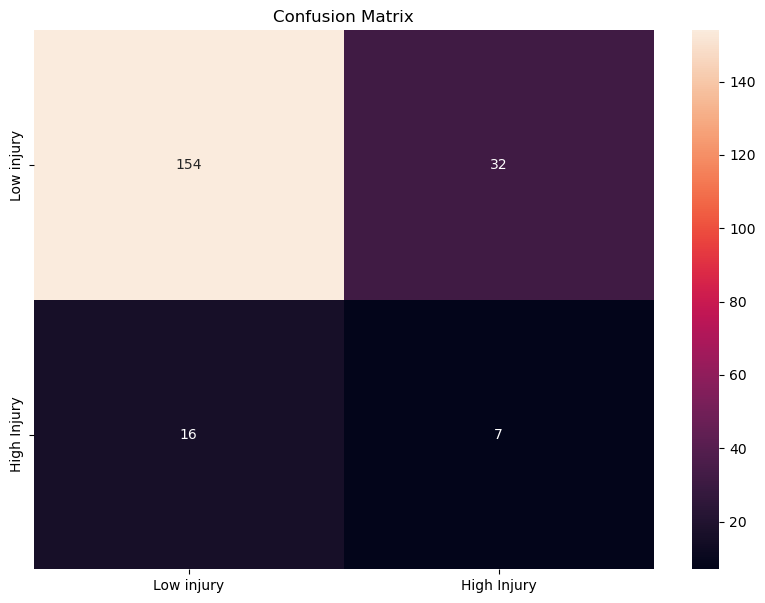

In [56]:
#Plot Heatmap
def plot_model(matrix):
    plt.figure(figsize=(10,7))
    sns.heatmap(matrix,annot=True,fmt='d', xticklabels=['Low injury','High Injury'], yticklabels=['Low injury','High Injury'])
    plt.title('Confusion Matrix')
    plt.show()
    
plot_model(matrix)
    

<span style="color: white"> End of KNN model building</span>